In [ ]:
import tensorflow as tf
import tensorflow.keras as tk
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

In [ ]:
dataset = tk.datasets.fashion_mnist

In [ ]:
(X_train,Y_train),(_,_) = dataset.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [ ]:
X_train = (X_train-127.5) / 127.5

In [ ]:
buffer_size = 60000
batch = 256

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch)

In [ ]:
def build_generator():
  model = tk.Sequential([
      layers.Dense((7*7*256),use_bias=False,input_shape = (128,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),

      layers.Reshape((7,7,256)),

      layers.Conv2DTranspose(128,(5,5),padding='same',use_bias = False),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),


      layers.Conv2DTranspose(64,(5,5),(2,2),padding='same',use_bias = False),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),


      layers.Conv2DTranspose(1,(5,5),(2,2),padding='same',use_bias = False,activation='tanh')

  ])

  model.summary()
  return model


In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1605632   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
def build_discriminator():
  model = tk.Sequential([
      layers.Conv2D(32,(5,5),(2,2),padding='same',input_shape=(28,28,1)),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),

      layers.Conv2D(64,(5,5),(2,2),padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),

      layers.Conv2D(128,(5,5),(2,2),padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),

      layers.Conv2D(256,(5,5),(2,2),padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),

      layers.Conv2D(512,(5,5),(2,2),padding='same'),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),

      layers.Flatten(),

      layers.Dense(1)


  ])

  model.summary()
  return model


In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)        

In [ ]:
def generator_loss(fake_output):
  g_loss =  -1*tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def discriminator_loss(real_output,fake_output,gradient_penality):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penality
  return d_loss

In [ ]:
@tf.function
def gradient_penality(real_images,fake_images,epsilon):
  interpolated_image = real_images*epsilon + fake_images * (1-epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_image)
    g_norm = discriminator(interpolated_image)[0]
  gradient = tape.gradient(g_norm,interpolated_image)
  gr_norm = tf.norm(gradient)
  penalty = tf.math.reduce_mean((gr_norm-1)**2)
  return penalty

In [ ]:
generator_optimizer = tf.optimizers.Adam(learning_rate=0.0003,beta_1=0.5,beta_2 =0.9)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0003,beta_1=0.5,beta_2 =0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 100
noise_dim = 128
number_of_images = 16
seed = tf.random.normal([number_of_images,noise_dim])

In [ ]:
def train(images):
  noise = tf.random.normal([batch,noise_dim])
  alpha = 5
  for i in range(alpha):
      with tf.GradientTape() as g_tape:
        generated_images = generator(noise,training = True)

        real_output = discriminator(images,training = True)
        fake_output = discriminator(generated_images,training = True)


        epsilon = tf.random.normal([batch,1,1,1],0.0,1.0)
        penalt = gradient_penality(images,generated_images,epsilon)

        disc_loss = discriminator_loss(real_output,fake_output,penalt)

      g_grad = g_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(g_grad,discriminator.trainable_variables))


  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise,training = True)
    fake_output = discriminator(generated_images,training= True)
    gen_loss=generator_loss(fake_output)
  gen_grad = gen_tape.gradient(gen_loss,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad,generator.trainable_variables))


In [ ]:
test_images = tf.random.normal([number_of_images,noise_dim])

In [ ]:
def create_and_save(model,epoch,seed):
  pred = model(seed,training = False)
  fig = plt.figure(figsize=(10,10))
  for i in range(pred.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(pred[i,:,:,0]* 127.5 + 127.5)
        plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [ ]:
def train_gan(data,epochs):
  for epoch in range(epochs):
    initial = time.time()
    for image_batch in data:
      if len(image_batch)==batch:
         train(image_batch)
    create_and_save(generator,epoch+1,seed)
    if (epoch+1) %10 == 0:
        checkpoint.save(checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch+1,time.time()-initial))
  create_and_save(generator,epochs,seed)
  generator.save('generator.h5')

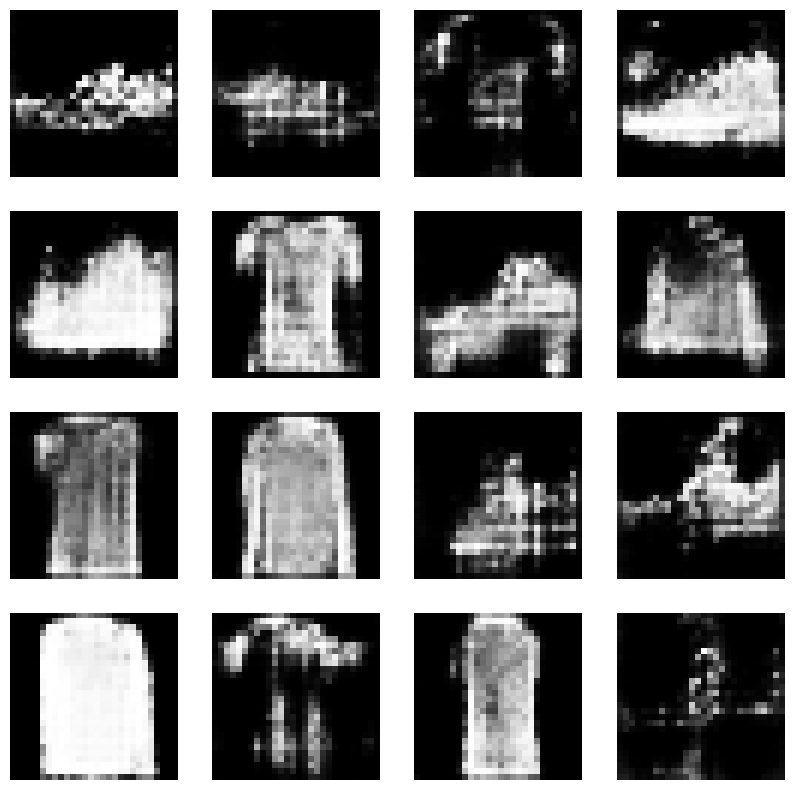

Time taken to process epoch 1 was 262.51107144355774 seconds


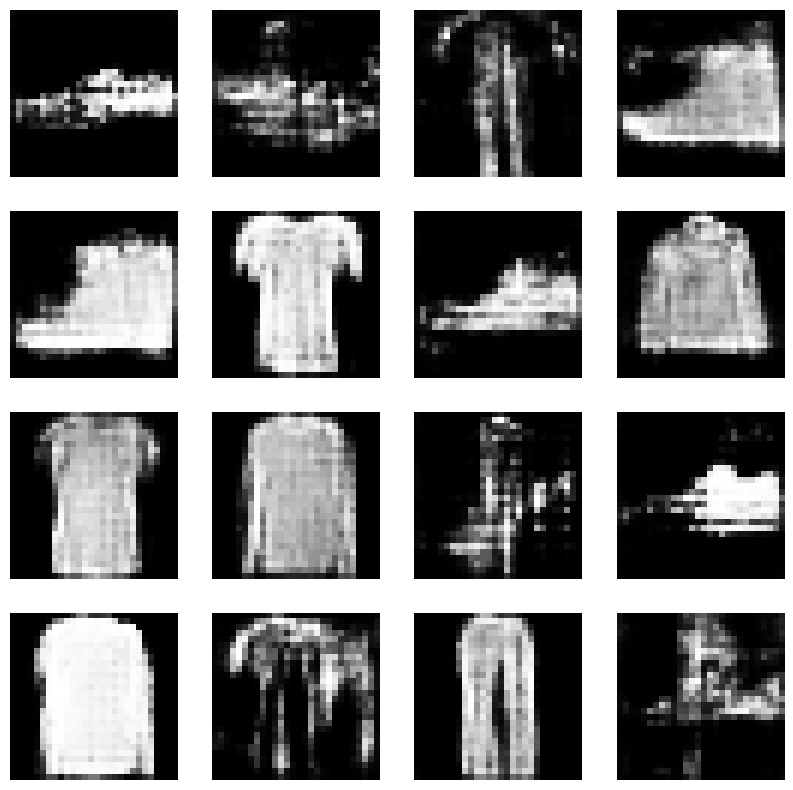

Time taken to process epoch 2 was 248.90200304985046 seconds


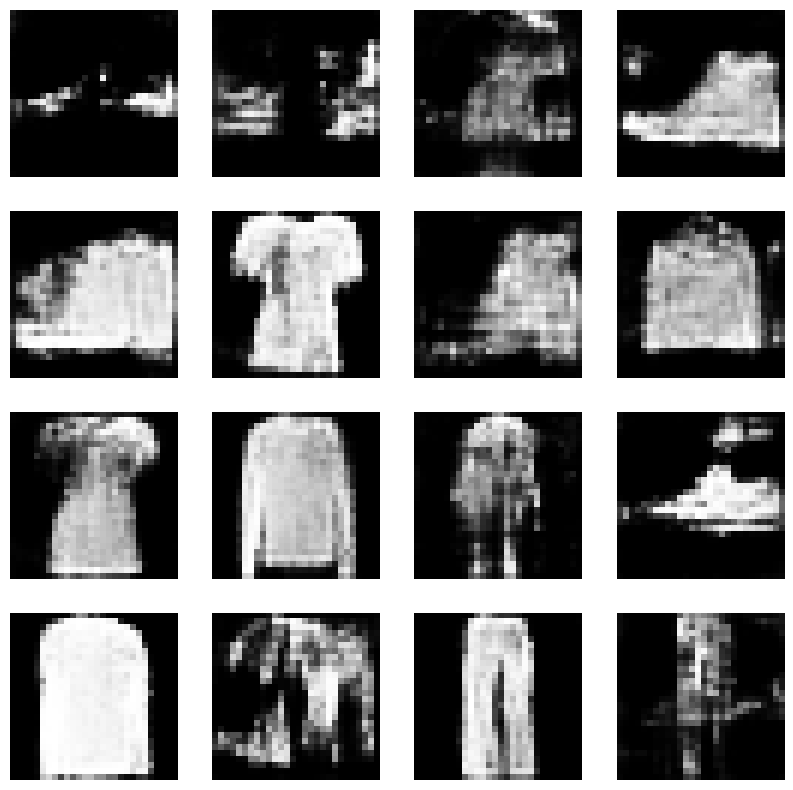

Time taken to process epoch 3 was 246.5099720954895 seconds


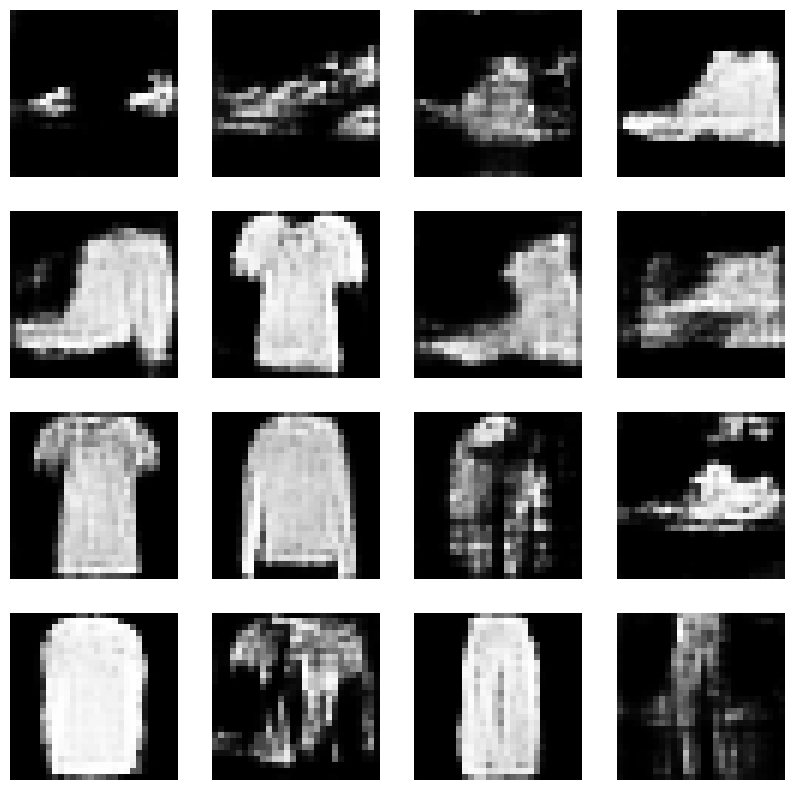

Time taken to process epoch 4 was 245.84551525115967 seconds


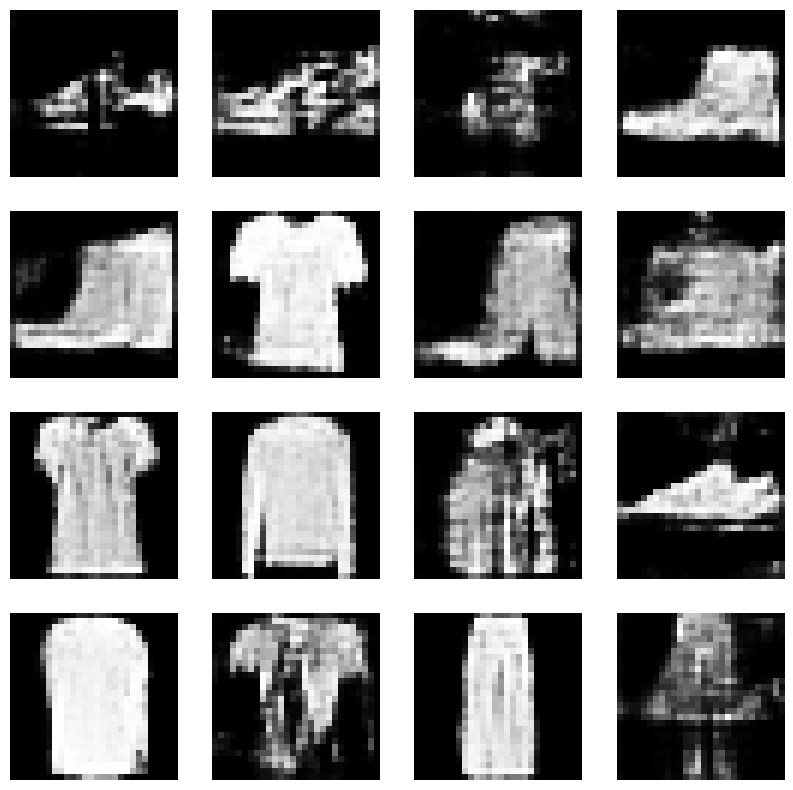

Time taken to process epoch 5 was 245.97630214691162 seconds


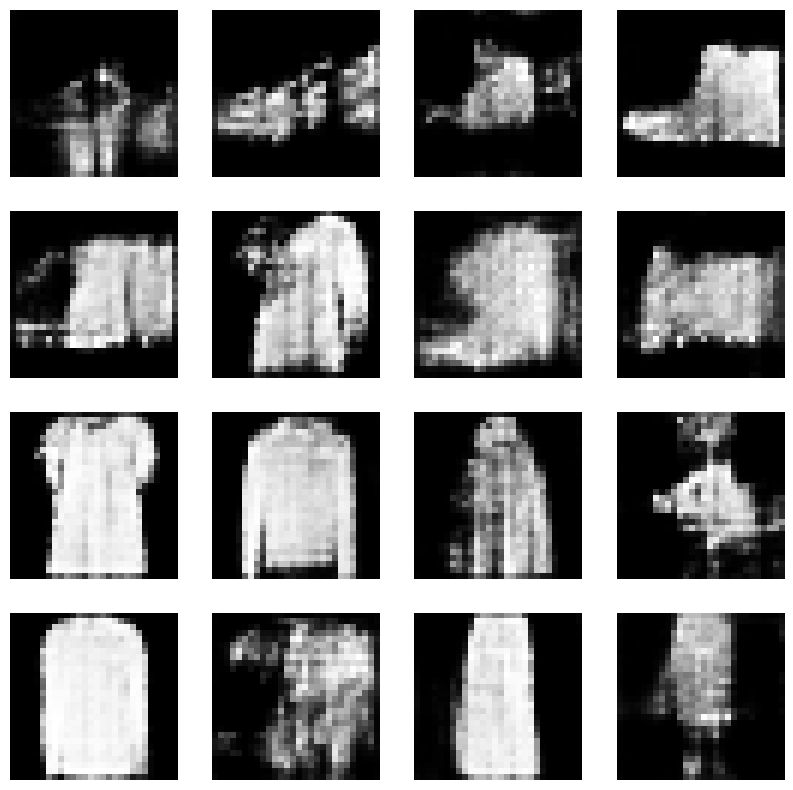

Time taken to process epoch 6 was 262.84405970573425 seconds


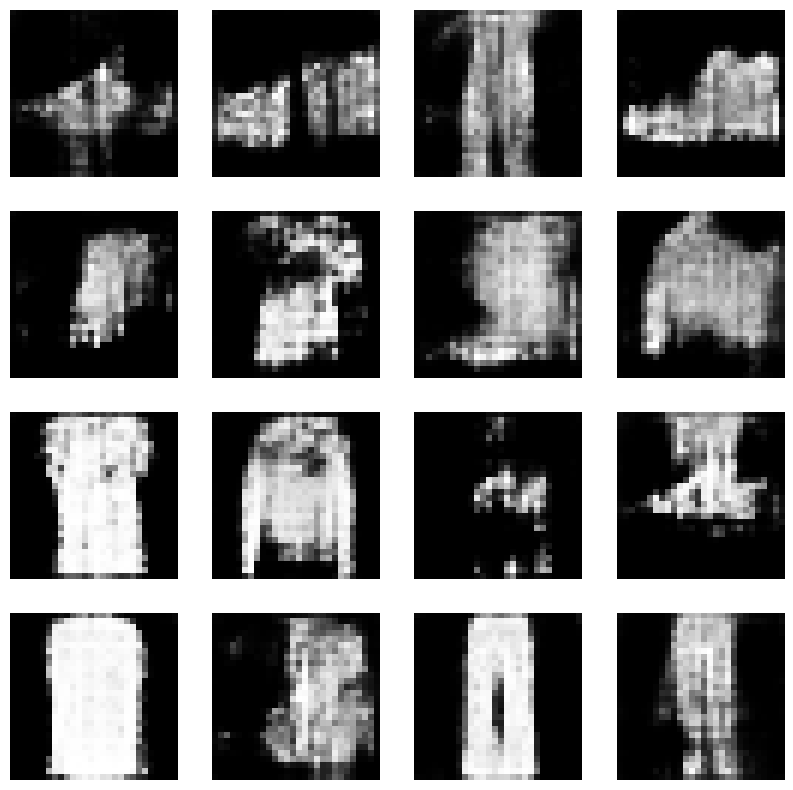

Time taken to process epoch 7 was 245.58952498435974 seconds


In [ ]:
train_gan(X_train,epochs)